In [1]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
IMG_SIZE = 224

In [3]:
# Define paths to images and labels
train_image_dir = '/kaggle/input/resized-2015-2019-blindness-detection-images/resized train 19'
train_label_file = '/kaggle/input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv'

In [4]:
# Load labels into a pandas dataframe
labels_df = pd.read_csv(train_label_file)

# Create a dictionary mapping image IDs to labels
label_dict = dict(zip(labels_df['id_code'], labels_df['diagnosis']))

In [5]:
# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image /= 255.0
    return image

In [6]:
# Define a function to get the label for an image
def get_label(image_path):
    image_id = os.path.basename(image_path).split('.')[0]
    res = np.zeros(5)
    res[label_dict[image_id]] = 1
    return res

In [7]:
# Get a list of image paths
image_paths = [os.path.join(train_image_dir, filename) for filename in os.listdir(train_image_dir)]

In [8]:
# Split the dataset into training, validation, and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, [get_label(path) for path in image_paths], test_size=0.2, random_state=50)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=50)

In [9]:
# Create a dataset of image paths
train_paths_ds = tf.data.Dataset.from_tensor_slices(train_paths)
val_paths_ds = tf.data.Dataset.from_tensor_slices(val_paths)
test_paths_ds = tf.data.Dataset.from_tensor_slices(test_paths)

In [10]:
# Load and preprocess the images
train_images_ds_1 = train_paths_ds.map(load_and_preprocess_image)
val_images_ds_1 = val_paths_ds.map(load_and_preprocess_image)
test_images_ds_1 = test_paths_ds.map(load_and_preprocess_image)

## Circular Cropping and Gaussian Blur

In [11]:
'''
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
reference - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.-Further-improve-by-auto-cropping
https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/1_eda.ipynb
'''

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """
    img = img.numpy()
    img = crop_image_from_gray(img)    
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , float(sigmaX)) ,-4 ,0.5)
    return img 

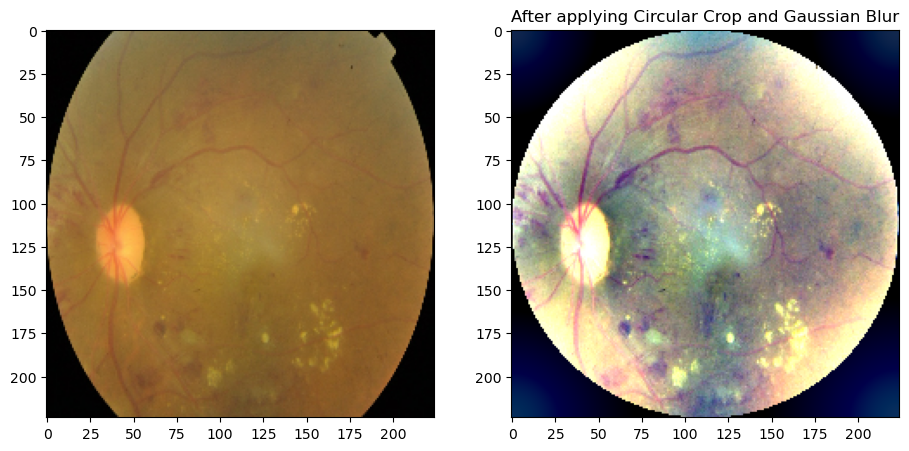

In [12]:
'''Perform Image Processing on a sample image'''
img = list(train_images_ds_1.take(1))[0]
#img = img_t
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

In [13]:
# Apply the function over the dataset
train_images_ds = train_images_ds_1.map(lambda x: tf.py_function(circle_crop, [x, 30], tf.float32))
val_images_ds = val_images_ds_1.map(lambda x: tf.py_function(circle_crop, [x, 30], tf.float32))
test_images_ds = test_images_ds_1.map(lambda x: tf.py_function(circle_crop, [x, 30], tf.float32))

In [14]:
# Combine the images and labels into a single dataset
train = tf.data.Dataset.zip((train_images_ds, tf.data.Dataset.from_tensor_slices(train_labels)))
val = tf.data.Dataset.zip((val_images_ds, tf.data.Dataset.from_tensor_slices(val_labels)))
test = tf.data.Dataset.zip((test_images_ds, tf.data.Dataset.from_tensor_slices(test_labels)))

In [15]:
train = train.batch(8)
train = train.prefetch(4)

In [16]:
test = test.batch(8)
test = test.prefetch(4)

In [17]:
val = val.batch(8)
val = val.prefetch(4)

In [18]:
train.as_numpy_iterator().next()

(array([[[[ 0.06582516,  0.15023184,  0.30666047],
          [ 0.06547713,  0.14995432,  0.30650568],
          [ 0.06443402,  0.14912197,  0.3060419 ],
          ...,
          [ 0.06991607,  0.15667719,  0.30436257],
          [ 0.07092804,  0.15747213,  0.3048162 ],
          [ 0.07126546,  0.15773702,  0.30496737]],
 
         [[ 0.06544706,  0.14993778,  0.3065042 ],
          [ 0.06509912,  0.14966023,  0.3063495 ],
          [ 0.0640558 ,  0.1488277 ,  0.30588576],
          ...,
          [ 0.06955394,  0.1563966 ,  0.30421096],
          [ 0.070566  ,  0.15719154,  0.30466455],
          [ 0.0709036 ,  0.15745667,  0.30481586]],
 
         [[ 0.06431299,  0.14905608,  0.30603582],
          [ 0.06396493,  0.1487785 ,  0.30588117],
          [ 0.06292105,  0.14794573,  0.30541712],
          ...,
          [ 0.06846771,  0.15555498,  0.30375648],
          [ 0.06948018,  0.15635023,  0.30421013],
          [ 0.0698179 ,  0.1566154 ,  0.3043614 ]],
 
         ...,
 
         [[ 

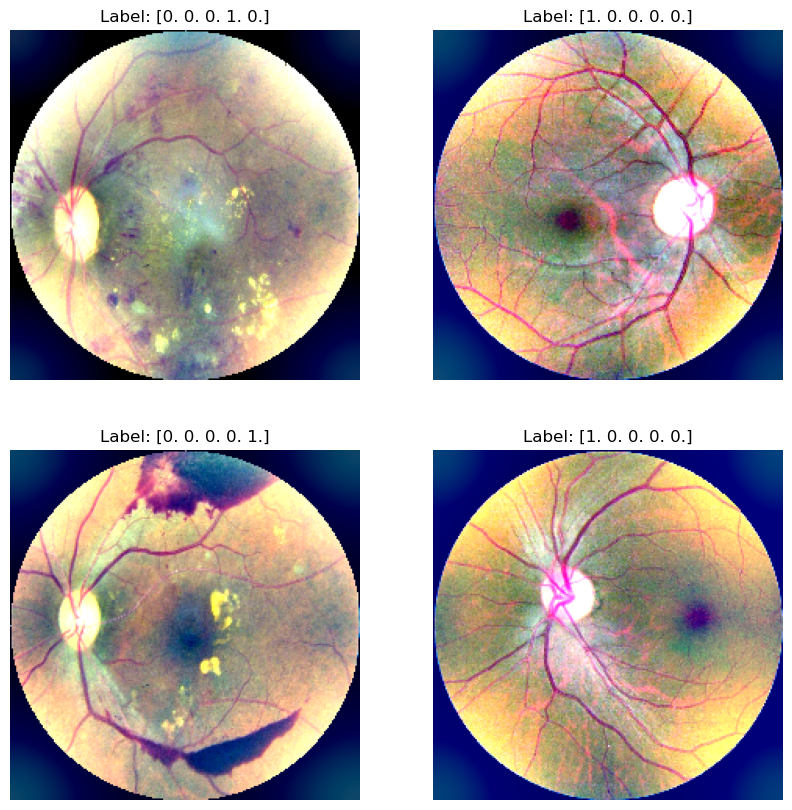

In [19]:
# Assuming the train_dataset is already loaded
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
train_plot = train.take(4)
for (img, label), ax in zip(train_plot, axs):
    ax.imshow(img.numpy()[0])
    ax.set_title(f"Label: {label.numpy()[0]}")
    ax.axis("off")

plt.show()

## Build the model

In [20]:
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
WARMUP_EPOCHS = 3

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [22]:
def build_model():
    # Load the pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add a global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer with 2048 neurons and ReLU activation
    x = Dense(2048, activation='relu')(x)
    
    # Dropout by 0.5
    x = Dropout(0.5)(x)

    # Add an output layer with 5 neurons (for the 5 classes) and softmax activation
    predictions = Dense(5, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [23]:
model = build_model()

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [26]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit(train, validation_data=val, epochs=WARMUP_EPOCHS)

Epoch 1/3
293/293 [==============================] - 75s 218ms/step - loss: 1.5131 - accuracy: 0.4469 - val_loss: 1.2621 - val_accuracy: 0.5410
Epoch 2/3
293/293 [==============================] - 57s 196ms/step - loss: 1.2779 - accuracy: 0.4921 - val_loss: 1.2187 - val_accuracy: 0.5887
Epoch 3/3
293/293 [==============================] - 57s 196ms/step - loss: 1.2364 - accuracy: 0.5198 - val_loss: 1.1942 - val_accuracy: 0.6348


In [27]:
# now make all layers trainable
for layer in model.layers:
    layer.trainable = True

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [29]:
history_finetunning = model.fit(train, validation_data=val, epochs=40, callbacks=callback_list, verbose=1)

Epoch 1/40
293/293 [==============================] - 110s 235ms/step - loss: 0.4679 - accuracy: 0.5809 - val_loss: 0.4254 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 2/40
293/293 [==============================] - 67s 228ms/step - loss: 0.3220 - accuracy: 0.6611 - val_loss: 0.4284 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 3/40
293/293 [==============================] - 66s 227ms/step - loss: 0.3076 - accuracy: 0.6722 - val_loss: 0.7105 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 4/40
293/293 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.6739
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293/293 [==============================] - 67s 229ms/step - loss: 0.3199 - accuracy: 0.6739 - val_loss: 152.2292 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 5/40
293/293 [==============================] - 68s 231ms/step - loss: 0.2715 - accuracy: 0.7102 - val_loss: 0.2502 - val_accuracy: 0.7270 - lr: 5.0000e-04
Epoch 6/40
293/293 [======================

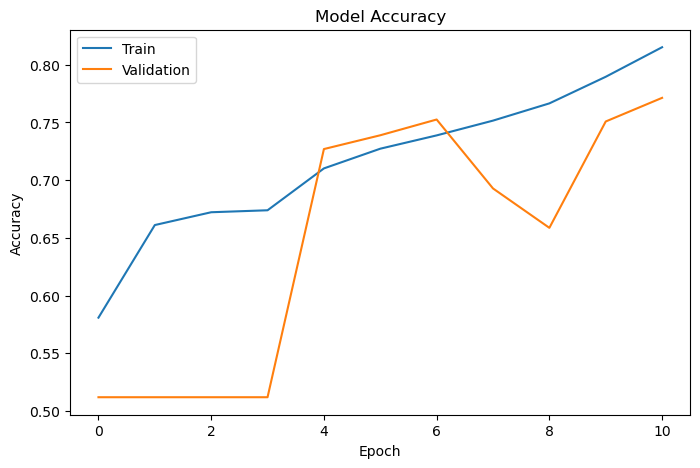

In [30]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning.history['accuracy'])
plt.plot(history_finetunning.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [32]:
model.save('blindnessdetection.h5')